In [60]:
!pip install pandas matplotlib seaborn networkx plotly

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 10.4 MB/s  0:00:00


In [61]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [42]:
dataset_path = 'dataset'

In [43]:
records = []

In [44]:
for fname in os.listdir(dataset_path):
    if fname.endswith('.json'):
        with open(os.path.join(dataset_path, fname), 'r') as f:
            data = json.load(f)

        instance = data['input']
        solution = data.get('solution', {})

        num_acts = len(instance['activities'])
        avg_modes = sum(len(act['modes']) for act in instance['activities']) / num_acts
        num_renew = len(instance['resources']['renewable'])
        num_nonrenew = len(instance['resources']['nonrenewable'])

        makespan = solution.get('makespan')

        total_renew = sum(sum(mode['renewable'][r] for mode in act['modes']) 
                          for act in instance['activities'] for r in range(num_renew))
        total_nonrenew = sum(sum(mode['nonrenewable'][r] for mode in act['modes']) 
                             for act in instance['activities'] for r in range(num_nonrenew))

        total_successors = sum(len(act['successors']) for act in instance['activities'])
        avg_successors = total_successors / num_acts

        records.append({
            'file': fname,
            'makespan': makespan,
            'num_activities': num_acts,
            'avg_modes': avg_modes,
            'num_renewable': num_renew,
            'num_nonrenewable': num_nonrenew,
            'total_renewable_demand': total_renew,
            'total_nonrenewable_demand': total_nonrenew,
            'avg_successors': avg_successors
        })

In [45]:
df = pd.DataFrame(records)

In [46]:
df.head(10)

,file,makespan,num_activities,avg_modes,num_renewable,num_nonrenewable,total_renewable_demand,total_nonrenewable_demand,avg_successors
0,instance_0000.json,31,14,3.571429,5,3,611,1587,1.285714
1,instance_0001.json,50,13,3.615385,5,3,540,1387,1.000000
2,instance_0002.json,36,11,3.909091,3,2,325,863,0.545455
3,instance_0003.json,16,12,3.750000,3,1,375,419,1.250000
4,instance_0004.json,22,11,3.636364,2,2,210,795,1.090909
5,instance_0005.json,38,18,3.722222,2,1,332,691,1.500000
6,instance_0006.json,37,15,3.666667,4,2,588,1158,1.266667
7,instance_0007.json,32,13,3.692308,2,2,227,1035,1.230769
8,instance_0008.json,24,14,3.357143,3,1,352,499,1.357143
9,instance_0009.json,33,10,4.000000,2,2,227,781,1.300000


In [47]:
df.describe(include='all')

,file,makespan,num_activities,avg_modes,num_renewable,num_nonrenewable,total_renewable_demand,total_nonrenewable_demand,avg_successors
count,100,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
unique,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,instance_0000.json,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,45.000000,15.92000,3.548055,3.550000,1.670000,506.230000,886.240000,1.314462
std,NaN,18.878666,4.98215,0.266559,1.095215,0.779212,230.065202,376.591629,0.263722
min,NaN,16.000000,10.00000,3.000000,2.000000,1.000000,141.000000,277.000000,0.300000
25%,NaN,31.750000,12.00000,3.372159,3.000000,1.000000,323.750000,571.500000,1.210714
50%,NaN,41.000000,15.00000,3.529412,3.000000,1.000000,451.000000,883.000000,1.333333
75%,NaN,57.000000,18.00000,3.750000,5.000000,2.000000,653.250000,1144.750000,1.485000


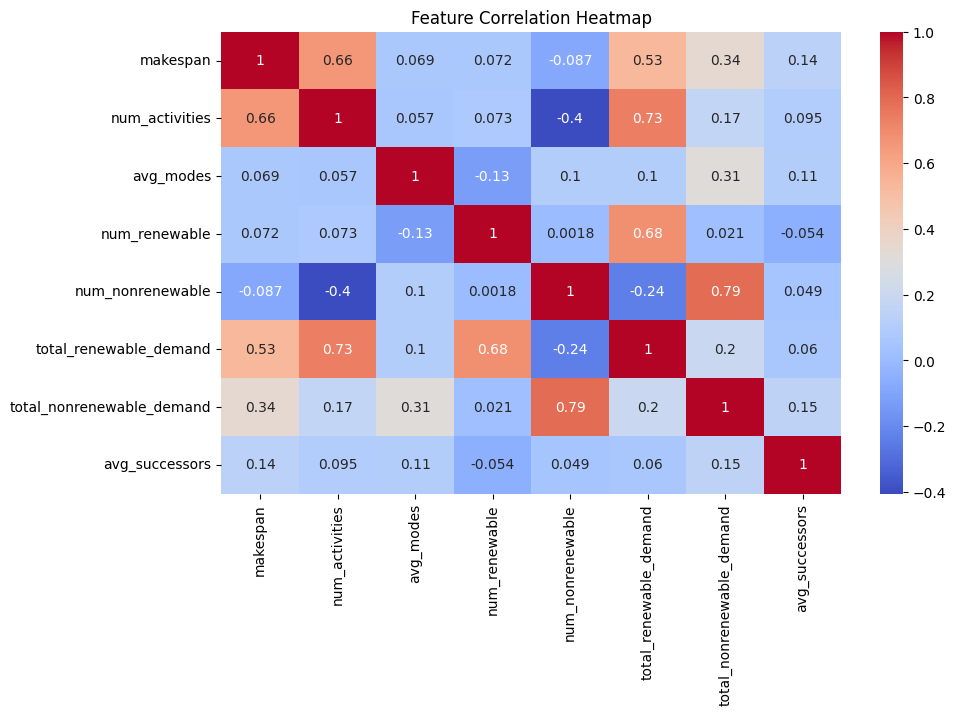

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

we can see makespan is heavily dependant on 'num_activities', 'total_renewable_demand' and 'total_nonrenewable_demand'

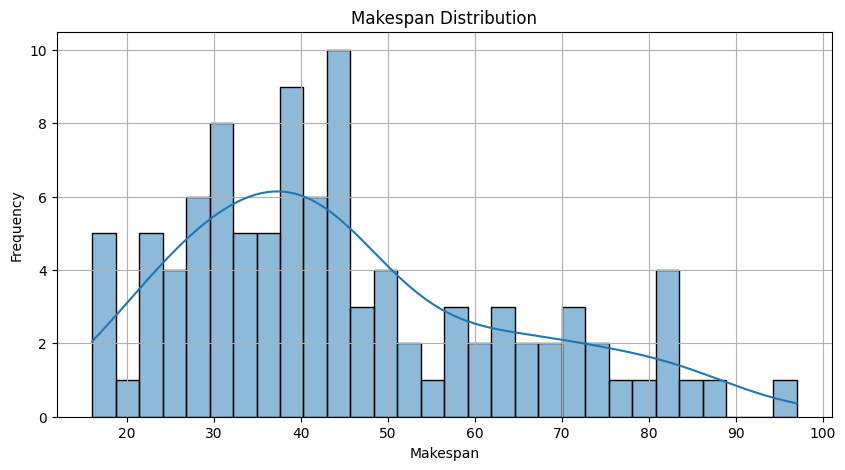

In [52]:
plt.figure(figsize=(10, 5))
sns.histplot(df['makespan'].dropna(), bins=30, kde=True)
plt.title("Makespan Distribution")
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

have a left sckrewed bell curve outliers on both side, the curve is centred around mean i.e 45 

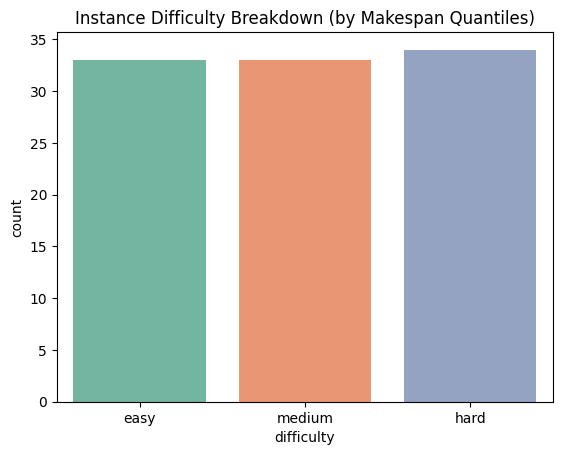

In [57]:
df['difficulty'] = pd.qcut(df['makespan'], q=3, labels=['easy', 'medium', 'hard'])

sns.countplot(data=df, x='difficulty', hue='difficulty', palette='Set2', legend=False)
plt.title("Instance Difficulty Breakdown (by Makespan Quantiles)")
plt.show()

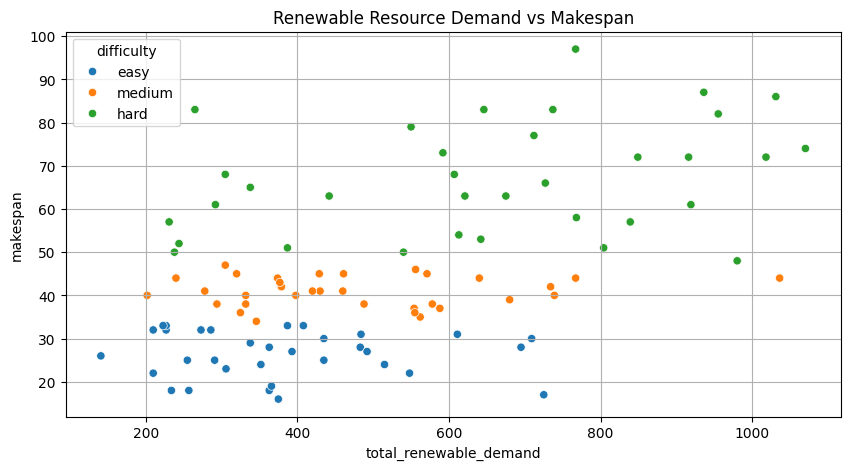

In [58]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='total_renewable_demand', y='makespan', hue='difficulty')
plt.title("Renewable Resource Demand vs Makespan")
plt.grid(True)
plt.show()

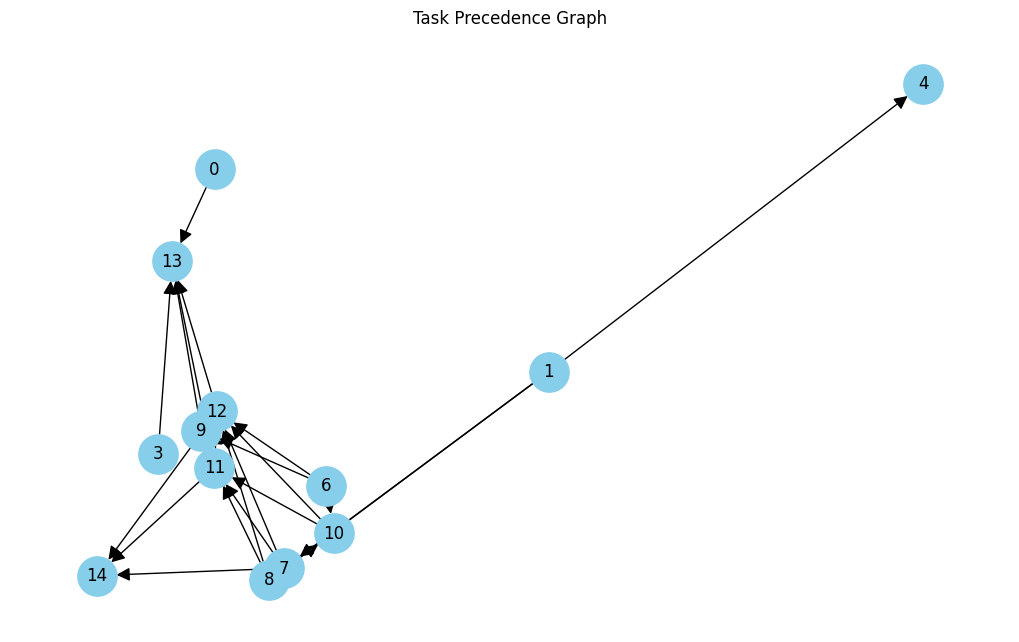

In [62]:
G = nx.DiGraph()
for act in data['input']['activities']:
    for succ in act['successors']:
        G.add_edge(act['id'], succ)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=800, arrowsize=20)
plt.title("Task Precedence Graph")
plt.show()

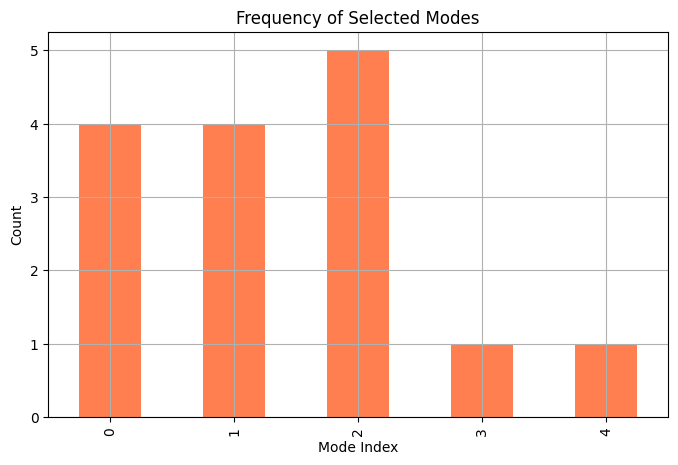

In [63]:
chosen_modes = [act['mode'] for act in data['solution']['activities']]
mode_counts = pd.Series(chosen_modes).value_counts().sort_index()

plt.figure(figsize=(8, 5))
mode_counts.plot(kind='bar', color='coral')
plt.title("Frequency of Selected Modes")
plt.xlabel("Mode Index")
plt.ylabel("Count")
plt.grid(True)
plt.show()